In [ ]:
from insightface.app import FaceAnalysis

app = FaceAnalysis(name="buffalo_l", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

In [1]:
from torchvision.io import read_video

video, audio, info = read_video("/fsx/rs2517/data/HDTF/cropped_videos_original/WDA_ElijahCummings_000.mp4")

/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [14]:
Image.fromarray(video[0].numpy()).save("face.png")

In [21]:
face_align.norm_crop??

Signature: face_align.norm_crop(img, landmark, image_size=112, mode='arcface')
Docstring: <no docstring>
Source:   
def norm_crop(img, landmark, image_size=112, mode='arcface'):
    M = estimate_norm(landmark, image_size, mode)
    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped
File:      ~/miniconda3/envs/svd/lib/python3.10/site-packages/insightface/utils/face_align.py
Type:      function

In [89]:
video.shape

torch.Size([6375, 772, 772, 3])

In [85]:
image = video[0]

app.prepare(ctx_id=0, det_size=(320, 320))

import time
from insightface.utils import face_align

start = time.time()
for i in range(10):
    for i in range(10):
        image = video[i].numpy()
        faces = app.get(image)
        faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)
print(faceid_embeds.shape)
        # face_roi = face_align.norm_crop(image,faces[0]['kps'],112)
print("Duration :", (time.time() - start)/10)

set det-size: (320, 320)
torch.Size([1, 512])
Duration : 0.19548144340515136


torch.Size([10, 512])
Duration : 0.2106628894805908
tensor(0.9961, device='cuda:0') tensor(-0.9961, device='cuda:0') tensor(0.9961, device='cuda:0')


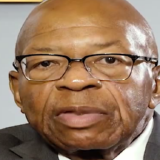

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1

import torch
import time
from PIL import Image

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=160, margin=20, min_face_size=20, post_process=True)  # Keep everything as default
mtcnn.to("cuda")
resnet = InceptionResnetV1(pretrained='vggface2').eval().to("cuda")

# Get cropped and prewhitened image tensor
with torch.no_grad():
    start = time.time()
    for i in range(10):
        img_cropped = mtcnn(video[:10].cuda(), device="cuda")
        img_cropped = torch.stack(img_cropped)
        img_embedding = resnet(img_cropped.permute(0,3,1,2))
print(img_embedding.shape)
print("Duration :", (time.time() - start)/10)
print(img_cropped[0].max(), img_cropped[0].min(), img_cropped[0].max())
img = Image.fromarray((((img_cropped[0]+1)/2)*255).clip(0,255).cpu().numpy().astype("uint8"))
img

In [15]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN()

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

from PIL import Image

img = Image.open("face.png")

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path="bite.png")

# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))

AttributeError: 'Image' object has no attribute 'float'

In [ ]:
from PIL import Image

img = Image.open()

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img, save_path=<optional save path>)

# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))

# Or, if using for VGGFace2 classification
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))

In [10]:
print(img_embedding.shape)
torch.nn.functional.cosine_similarity(img_embedding[0],img_embedding[-1], dim=0)

torch.Size([10, 512])


tensor(0.9635, device='cuda:0')

In [33]:
img_cropped[0].min(), img_cropped[0].max()

(tensor(-0.9961), tensor(0.9961))

In [13]:
image_encoder_path = "/data/home/antoni/code/generative-models/checkpoints/image_encoder"

from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection

image_encoder = CLIPVisionModelWithProjection.from_pretrained(image_encoder_path).to(
            "cuda"
        )
clip_image_processor = CLIPImageProcessor()

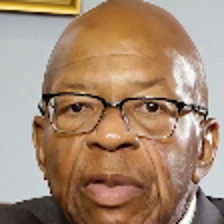

In [10]:
from PIL import Image
Image.fromarray(face_roi).resize((224, 224))

In [54]:
clip_image = clip_image_processor(images=image.numpy()[None, ...], return_tensors="pt").pixel_values
clip_image = clip_image.to("cuda")
clip_image_embeds = image_encoder(clip_image, output_hidden_states=True).hidden_states[-1]

In [59]:
class ImageProjModel(torch.nn.Module):
    """Projection Model"""

    def __init__(self, cross_attention_dim=1024, clip_embeddings_dim=1024, clip_extra_context_tokens=4):
        super().__init__()

        self.generator = None
        self.cross_attention_dim = cross_attention_dim
        self.clip_extra_context_tokens = clip_extra_context_tokens
        self.proj = torch.nn.Linear(clip_embeddings_dim, self.clip_extra_context_tokens * cross_attention_dim)
        self.norm = torch.nn.LayerNorm(cross_attention_dim)

    def forward(self, image_embeds):
        embeds = image_embeds
        clip_extra_context_tokens = self.proj(embeds).reshape(
            -1, self.clip_extra_context_tokens, self.cross_attention_dim
        )
        clip_extra_context_tokens = self.norm(clip_extra_context_tokens)
        return clip_extra_context_tokens

image_proj_model = ImageProjModel(
        cross_attention_dim=self.pipe.unet.config.cross_attention_dim,
        clip_embeddings_dim=self.image_encoder.config.projection_dim,
        clip_extra_context_tokens=self.num_tokens,
    ).to(self.device, dtype=self.torch_type)

state_dict = torch.load("/data/home/antoni/code/ID-Animator/ID-Animator/animator.ckpt", map_location="cpu")
if 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']
    image_proj_dict={}
    face_adapter_proj={}
    for k,v in state_dict.items():
        if k.startswith("module.image_proj_model"):
            image_proj_dict[k.replace("module.image_proj_model.", "")] = state_dict[k]
        elif k.startswith("module.adapter_modules."):
            face_adapter_proj[k.replace("module.adapter_modules.", "")] = state_dict[k]
        elif k.startswith("image_proj_model"):
            image_proj_dict[k.replace("image_proj_model.", "")] = state_dict[k]
        elif k.startswith("adapter_modules."):
            face_adapter_proj[k.replace("adapter_modules.", "")] = state_dict[k]
        else:
            print("ERROR!")
            return
    state_dict = {}
    state_dict['image_proj'] = image_proj_dict
    state_dict["face_adapter"] = face_adapter_proj
image_proj_model.load_state_dict(state_dict["image_proj"])

torch.Size([1, 1024])